In [ ]:
#@title Connections
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/Colab Notebooks/PADAM/'

# Check GPU Info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mounted at /content/drive
Sat Jan 21 03:57:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

In [ ]:
#@title imports
!pip install adabound
#!pip install merlin-dataloader

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from torch.optim import Adam

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import os
import argparse

from torch.autograd import Variable

from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR

import adabound

import json
from copy import deepcopy

import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title utils
'''Some helper functions for PyTorch, including:
    - get_mean_and_std: calculate the mean and std value of dataset.
    - msr_init: net parameter initialization.
    - progress_bar: progress bar mimic xlua.progress.
'''
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)


# _, term_width = os.popen('stty size', 'r').read().split()
# term_width = int(term_width)
term_width=20

TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(str(msg))
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f


In [ ]:
#@title VGG
'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn
from torch.autograd import Variable


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name, num_classes = 10):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

# net = VGG('VGG11')
# x = torch.randn(2,3,32,32)
# print(net(Variable(x)).size())


In [ ]:
#@title train_loop( ) and test_loop( )
def train_loop(trainloader, model, criterion, optimizer, use_cuda, train_errs, train_losses):
    # Training
    model.train()  
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        def closure():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            return loss

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step(closure)

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                      % (train_loss/(batch_idx+1), 100.0/total*(correct), correct, total))

    # Compute training error
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                      % (train_loss/(batch_idx+1), 100.0/total*(correct), correct, total))
    train_errs.append(1 - correct/total)
    train_losses.append(train_loss/(batch_idx+1))


def test_loop(testloader, model, criterion, use_cuda, test_errs, test_losses):
    # Testing
    model.eval()  
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()

        progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                      % (test_loss/(batch_idx+1), 100.0 / total * (correct), correct, total))
    test_errs.append(1 - correct/total)
    test_losses.append(test_loss/(batch_idx+1))



In [ ]:
#@title Data Loader

def load_cifar10():
    print('==> Preparing cifar10 data..')
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                              (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                              (0.2023, 0.1994, 0.2010)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=f'{path}/data/', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(
        root=f'{path}/data/', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=100, shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck')
    return trainloader, testloader


def load_cifar100():
    print('==> Preparing cifar100 data..')
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
    ])

    trainset = torchvision.datasets.CIFAR100(root=path+'/data/CIFAR100', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR100(root=path+'/data/CIFAR100', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    return trainloader, testloader



In [ ]:
#@title def adam_switch_sgdm(switch,lr_sgdm,dataset)
def adam_switch_sgdm(switch,lr_sgdm,dataset):
    # Hyperparameters ##############################################
    # switch=switch
    # lr=0.001
    lr_adam=0.001
    # lr_sgdm=lr_sgdm
    net="vggnet"
    method=f"adam_switch_sgdm_switch={switch}_lr={lr_adam}_{lr_sgdm}" #{lr_sgdm}
    wd = 5e-4
    beta1 = 0.5
    beta2 = 0.999
    Nepoch=200
    resume=True

    print(method)

    # init #########################################################
    results_path=f'{path}/checkpoint/{net}/{dataset}/{method}'
    use_cuda = torch.cuda.is_available()
    best_acc = 0  # best test accuracy
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch
    train_errs = []
    test_errs = []
    train_losses = []
    test_losses = []
    lrs = []

    # Data #########################################################
    if dataset == 'CIFAR10':
        trainloader, testloader = load_cifar10()
    elif dataset == 'CIFAR100':
        trainloader, testloader = load_cifar100()
    else:
        print(f'{dataset} Not Available!')
        return 0

    # Model #########################################################
    if resume:
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        try:
            checkpoint = torch.load(results_path)
            model = checkpoint['model']
            start_epoch = checkpoint['epoch']
            train_losses = checkpoint['train_losses']
            train_errs = checkpoint['train_errs']
            test_losses = checkpoint['test_losses']
            test_errs = checkpoint['test_errs']
            best_acc = checkpoint['best_acc']
            lrs = checkpoint['lrs']
            lr=lrs[-1]
        except Exception as e:
            print(e)
            print('==> Building model..')
            if net == 'vggnet':
                model = VGG('VGG16', num_classes=10)
            # #     model = models.vgg16_bn(num_classes=10)
            # elif net == 'resnet':
            #     model = ResNet18(num_classes=10)
            # #     model = models.resnet18(num_classes=10)
            # elif net == 'wideresnet':
            #     model = WResNet_cifar10(
            #         num_classes=10, depth=16, multiplier=4)
            else:
                print('Network undefined!')
    else:
        print('==> Building model..')
        if net == 'vggnet':
            model = VGG('VGG16', num_classes=10)
        # #     model = models.vgg16_bn(num_classes=10)
        # elif net == 'resnet':
        #     model = ResNet18(num_classes=10)
        # #     model = models.resnet18(num_classes=10)
        # elif net == 'wideresnet':
        #     model = WResNet_cifar10(
        #         num_classes=10, depth=16, multiplier=4)
        else:
            print('Network undefined!')

    if use_cuda:
        model.cuda()
        model = torch.nn.DataParallel(
            model, device_ids=range(torch.cuda.device_count()))
        cudnn.benchmark = True


    # Optimize/Train #####################################
    criterion = nn.CrossEntropyLoss()

    ### Adam
    betas = (beta1, beta2)
    optimizer = Adam(model.parameters(), lr=lr_adam, weight_decay = wd, betas = betas)
    milestones=[150-start_epoch]
    scheduler = MultiStepLR(optimizer, milestones=[i for i in milestones if i>0], gamma=0.1)

    for epoch in range(start_epoch+1, switch+1):
        print('\nEpoch: %d' % epoch, ' Learning rate:', scheduler.get_last_lr(), ' best_acc: ', best_acc)
        # Train
        train_loop(trainloader=trainloader, model=model, 
                    criterion=criterion, optimizer=optimizer,
                    use_cuda=use_cuda,train_errs=train_errs,train_losses=train_losses)
        # Test
        test_loop(testloader=testloader, model=model, criterion=criterion, 
                  use_cuda=use_cuda, test_errs=test_errs, test_losses=test_losses)
        # Save checkpoint
        acc = 100.0 * (1-test_errs[-1])
        if acc > best_acc:
            best_acc = acc
        lrs.extend(scheduler.get_last_lr())
        print('Saving..')
        state = {
            'model': model,
            'epoch': epoch,
            'best_acc': best_acc,
            'train_errs': train_errs,
            'train_losses': train_losses,
            'test_errs': test_errs,
            'test_losses': test_losses,
            'lrs': lrs
        }
        torch.save(state, results_path)

        scheduler.step()

    if lr_sgdm > 0:
        # Switch to SGDM
        print('============ Switch to sgdm ==========')
        optimizer = optim.SGD(model.parameters(), lr=lr_sgdm, momentum= 0.9,weight_decay = wd)
        milestones=[100-max(switch,start_epoch),150-max(switch,start_epoch)]
        # milestones=[150-max(switch,start_epoch)]
        print([i for i in milestones if i>0])
        scheduler = MultiStepLR(optimizer, milestones=[i for i in milestones if i>0], gamma=0.1)

        for epoch in range(max(switch+1,start_epoch+1), 200+1):
            print('\nEpoch: %d' % epoch, ' Learning rate:', scheduler.get_last_lr(), ' best_acc: ', best_acc)
            # Train
            train_loop(trainloader=trainloader, model=model, 
                        criterion=criterion, optimizer=optimizer,
                        use_cuda=use_cuda,train_errs=train_errs,train_losses=train_losses)
            # Test
            test_loop(testloader=testloader, model=model, criterion=criterion, 
                      use_cuda=use_cuda, test_errs=test_errs, test_losses=test_losses)
            # Save checkpoint
            acc = 100.0 * (1-test_errs[-1])
            if acc > best_acc:
                best_acc = acc
            lrs.extend(scheduler.get_last_lr())
            print('Saving..')
            state = {
                'model': model,
                'epoch': epoch,
                'best_acc': best_acc,
                'train_errs': train_errs,
                'train_losses': train_losses,
                'test_errs': test_errs,
                'test_losses': test_losses,
                'lrs': lrs
            }
            torch.save(state, results_path)

            scheduler.step()


In [ ]:

for switch in [25]:
  for lr_sgdm in [0.001,0.003,0.005,0.007,0.009,0.01,0.03,0.04,0.05,0.07,0.09,0.1,0.11]:
    adam_switch_sgdm(switch,lr_sgdm,'CIFAR10')


adam_switch_sgdm_switch=25_lr=0.001_0.001
==> Preparing cifar10 data..
Files already downloaded and verified
Files already downloaded and verified
==> Resuming from checkpoint..
============ Switch to sgdm ==========
[]
adam_switch_sgdm_switch=25_lr=0.001_0.003
==> Preparing cifar10 data..
Files already downloaded and verified
Files already downloaded and verified
==> Resuming from checkpoint..
============ Switch to sgdm ==========
[]
adam_switch_sgdm_switch=25_lr=0.001_0.005
==> Preparing cifar10 data..
Files already downloaded and verified
Files already downloaded and verified
==> Resuming from checkpoint..
============ Switch to sgdm ==========
[]
adam_switch_sgdm_switch=25_lr=0.001_0.007
==> Preparing cifar10 data..
Files already downloaded and verified
Files already downloaded and verified
==> Resuming from checkpoint..
============ Switch to sgdm ==========
[]
adam_switch_sgdm_switch=25_lr=0.001_0.009
==> Preparing cifar10 data..
Files already downloaded and verified
Files alrea

# backup

In [ ]:
#@title plot
def plot_re(methods, dataset, net='vggnet'):
    checkpoints={}
    for i in methods:
      checkpoints[i]=torch.load(f'{path}checkpoint/{net}/{dataset}/{i}',map_location=torch.device('cpu'))

    fig, ax = plt.subplots(2,figsize=(15, 15))

    for i in methods:
      ax[0].plot(checkpoints[i]['train_losses'], label=i)
    ax[0].set_title('train_losses')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylim([0, 1])

    for i in methods:
      ax[1].plot(checkpoints[i]['test_errs'], label=i)
    ax[1].set_title('test_errs')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylim([0, 0.2])

    fig.suptitle(net)
    plt.show()

def plot_lrs(methods, dataset, net='vggnet'):
    checkpoints={}
    for i in methods:
      checkpoints[i]=torch.load(f'{path}/checkpoint/{net}/{dataset}/{i}',map_location=torch.device('cpu'))

    fig, ax = plt.subplots(1,figsize=(15, 15))

    for i in methods:
      ax.plot(checkpoints[i]['lrs'], label=i)
    ax.set_title('lrs')
    ax.legend()
    ax.set_xlabel('Epochs')

    fig.suptitle(net)
    plt.show()

In [ ]:
#@title CIFAR100 adam switch sgdm

# Hyperparameters ##############################################
switch=100
# lr=0.001
lr_adam=0.001
lr_sgdm=0.01
net="vggnet"
method=f"adam_switch_sgdm_switch={switch}_lr={lr_adam}_{lr_sgdm}" #{lr_sgdm}
wd = 5e-4
beta1 = 0.9
beta2 = 0.999
Nepoch=200
resume=True

print(method)

# init #########################################################
results_path=f'{path}/checkpoint/{net}/CIFAR100/{method}'
use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
train_errs = []
test_errs = []
train_losses = []
test_losses = []
lrs = []

# Data #########################################################
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
])


trainset = torchvision.datasets.CIFAR100(root='./data/CIFAR100', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data/CIFAR100', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


# Model #########################################################
if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    try:
        checkpoint = torch.load(results_path)
        model = checkpoint['model']
        start_epoch = checkpoint['epoch']
        train_losses = checkpoint['train_losses']
        train_errs = checkpoint['train_errs']
        test_losses = checkpoint['test_losses']
        test_errs = checkpoint['test_errs']
        best_acc = checkpoint['best_acc']
        lrs = checkpoint['lrs']
        lr=lrs[-1]
    except Exception as e:
        print(e)
        print('==> Building model..')
        if net == 'vggnet':
            model = VGG('VGG16', num_classes=10)
        # #     model = models.vgg16_bn(num_classes=10)
        # elif net == 'resnet':
        #     model = ResNet18(num_classes=10)
        # #     model = models.resnet18(num_classes=10)
        # elif net == 'wideresnet':
        #     model = WResNet_cifar100(
        #         num_classes=10, depth=16, multiplier=4)
        else:
            print('Network undefined!')
else:
    print('==> Building model..')
    if net == 'vggnet':
        model = VGG('VGG16', num_classes=10)
    # #     model = models.vgg16_bn(num_classes=10)
    # elif net == 'resnet':
    #     model = ResNet18(num_classes=10)
    # #     model = models.resnet18(num_classes=10)
    # elif net == 'wideresnet':
    #     model = WResNet_cifar100(
    #         num_classes=10, depth=16, multiplier=4)
    else:
        print('Network undefined!')

if use_cuda:
    model.cuda()
    model = torch.nn.DataParallel(
        model, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True


# Optimize/Train #####################################
criterion = nn.CrossEntropyLoss()

### Adam
betas = (beta1, beta2)
optimizer = Adam(model.parameters(), lr=lr_adam, weight_decay = wd, betas = betas)
milestones=[150-start_epoch]
scheduler = MultiStepLR(optimizer, milestones=[i for i in milestones if i>0], gamma=0.1)

for epoch in range(start_epoch+1, switch+1):
    print('\nEpoch: %d' % epoch, ' Learning rate:', scheduler.get_last_lr(), ' best_acc: ', best_acc)
    # Train
    train_loop(trainloader=trainloader, model=model, 
                criterion=criterion, optimizer=optimizer,
                use_cuda=use_cuda,train_errs=train_errs,train_losses=train_losses)
    # Test
    test_loop(testloader=testloader, model=model, criterion=criterion, 
              use_cuda=use_cuda, test_errs=test_errs, test_losses=test_losses)
    # Save checkpoint
    acc = 100.0 * (1-test_errs[-1])
    if acc > best_acc:
        best_acc = acc
    lrs.extend(scheduler.get_last_lr())
    print('Saving..')
    state = {
        'model': model,
        'epoch': epoch,
        'best_acc': best_acc,
        'train_errs': train_errs,
        'train_losses': train_losses,
        'test_errs': test_errs,
        'test_losses': test_losses,
        'lrs': lrs
    }
    torch.save(state, results_path)

    scheduler.step()

if lr_sgdm > 0:
    # Switch to SGDM
    print('============ Switch to sgdm ==========')
    optimizer = optim.SGD(model.parameters(), lr=lr_sgdm, momentum= 0.9,weight_decay = wd)
    milestones=[100-max(switch,start_epoch),150-max(switch,start_epoch)]
    # milestones=[150-max(switch,start_epoch)]
    print([i for i in milestones if i>0])
    scheduler = MultiStepLR(optimizer, milestones=[i for i in milestones if i>0], gamma=0.1)

    for epoch in range(max(switch+1,start_epoch+1), 200+1):
        print('\nEpoch: %d' % epoch, ' Learning rate:', scheduler.get_last_lr(), ' best_acc: ', best_acc)
        # Train
        train_loop(trainloader=trainloader, model=model, 
                    criterion=criterion, optimizer=optimizer,
                    use_cuda=use_cuda,train_errs=train_errs,train_losses=train_losses)
        # Test
        test_loop(testloader=testloader, model=model, criterion=criterion, 
                  use_cuda=use_cuda, test_errs=test_errs, test_losses=test_losses)
        # Save checkpoint
        acc = 100.0 * (1-test_errs[-1])
        if acc > best_acc:
            best_acc = acc
        lrs.extend(scheduler.get_last_lr())
        print('Saving..')
        state = {
            'model': model,
            'epoch': epoch,
            'best_acc': best_acc,
            'train_errs': train_errs,
            'train_losses': train_losses,
            'test_errs': test_errs,
            'test_losses': test_losses,
            'lrs': lrs
        }
        torch.save(state, results_path)

        scheduler.step()


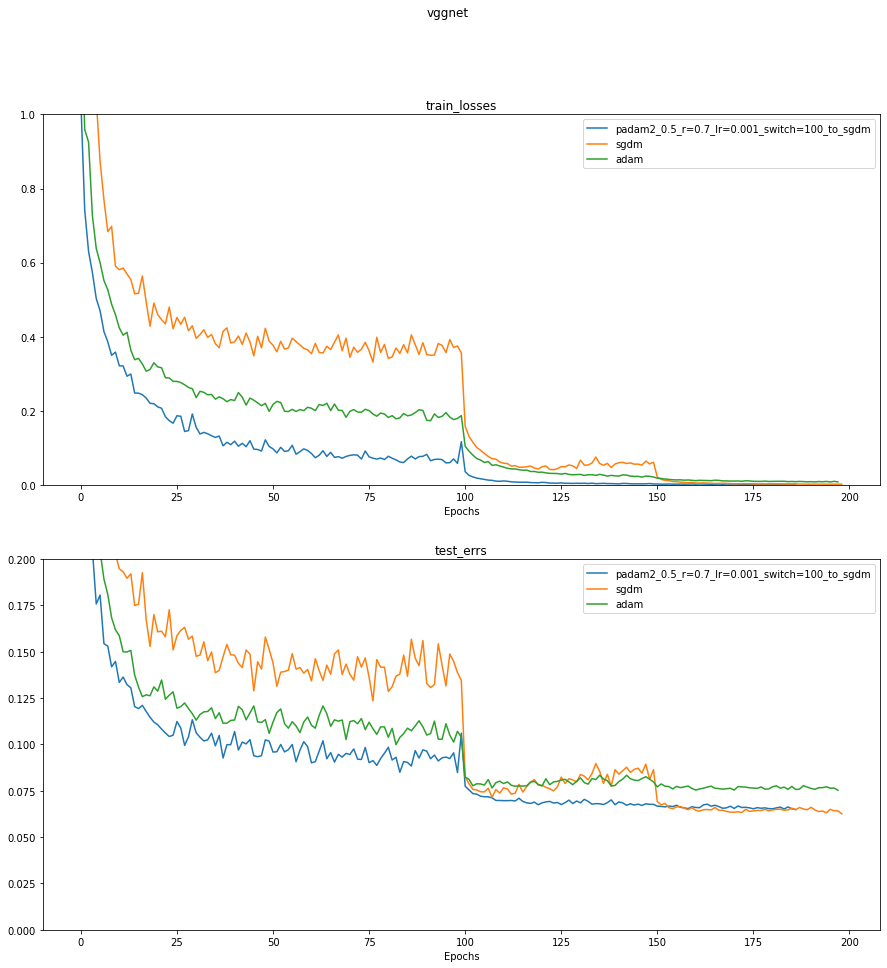

In [ ]:
# methods=['padam2_0.5_0.5_0.001','padam2_0.5_0.3_0.001','padam2_0.5_0.7_0.001','padam2_0.5_0.9_0.001']
# methods=['padam2_0.5_0.7_0.001','sgdm','adam','padam2_sgdm2_dampening=0.9']
# methods=['padam2_0.5_r=0.7_lr=0.001_switch=100_to_sgdm','sgdm','adam','padam2_sgdm2_dampening=0.9']
methods=['padam2_0.5_r=0.7_lr=0.001_switch=100_to_sgdm','sgdm','adam','adam_switch_sgdm_switch=100_lr=0.001']
plot_re('vggnet', methods=methods)


In [ ]:
#@title CIFAR10 adam switch sgdm

# Hyperparameters ##############################################
switch=25
# lr=0.001
lr_adam=0.001
lr_sgdm=0.05
net="vggnet"
method=f"adam_switch_sgdm_switch={switch}_lr={lr_adam}_{lr_sgdm}" #{lr_sgdm}
wd = 5e-4
beta1 = 0.5
beta2 = 0.999
Nepoch=200
resume=True

print(method)

# init #########################################################
results_path=f'{path}/checkpoint/{net}/CIFAR10/{method}'
use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
train_errs = []
test_errs = []
train_losses = []
test_losses = []
lrs = []

# Data #########################################################
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                          (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                          (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root=f'{path}/data/', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root=f'{path}/data/', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
            'dog', 'frog', 'horse', 'ship', 'truck')


# Model #########################################################
if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    try:
        checkpoint = torch.load(results_path)
        model = checkpoint['model']
        start_epoch = checkpoint['epoch']
        train_losses = checkpoint['train_losses']
        train_errs = checkpoint['train_errs']
        test_losses = checkpoint['test_losses']
        test_errs = checkpoint['test_errs']
        best_acc = checkpoint['best_acc']
        lrs = checkpoint['lrs']
        lr=lrs[-1]
    except Exception as e:
        print(e)
        print('==> Building model..')
        if net == 'vggnet':
            model = VGG('VGG16', num_classes=10)
        # #     model = models.vgg16_bn(num_classes=10)
        # elif net == 'resnet':
        #     model = ResNet18(num_classes=10)
        # #     model = models.resnet18(num_classes=10)
        # elif net == 'wideresnet':
        #     model = WResNet_cifar10(
        #         num_classes=10, depth=16, multiplier=4)
        else:
            print('Network undefined!')
else:
    print('==> Building model..')
    if net == 'vggnet':
        model = VGG('VGG16', num_classes=10)
    # #     model = models.vgg16_bn(num_classes=10)
    # elif net == 'resnet':
    #     model = ResNet18(num_classes=10)
    # #     model = models.resnet18(num_classes=10)
    # elif net == 'wideresnet':
    #     model = WResNet_cifar10(
    #         num_classes=10, depth=16, multiplier=4)
    else:
        print('Network undefined!')

if use_cuda:
    model.cuda()
    model = torch.nn.DataParallel(
        model, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True


# Optimize/Train #####################################
criterion = nn.CrossEntropyLoss()

### Adam
betas = (beta1, beta2)
optimizer = Adam(model.parameters(), lr=lr_adam, weight_decay = wd, betas = betas)
milestones=[150-start_epoch]
scheduler = MultiStepLR(optimizer, milestones=[i for i in milestones if i>0], gamma=0.1)

for epoch in range(start_epoch+1, switch+1):
    print('\nEpoch: %d' % epoch, ' Learning rate:', scheduler.get_last_lr(), ' best_acc: ', best_acc)
    # Train
    train_loop(trainloader=trainloader, model=model, 
                criterion=criterion, optimizer=optimizer,
                use_cuda=use_cuda,train_errs=train_errs,train_losses=train_losses)
    # Test
    test_loop(testloader=testloader, model=model, criterion=criterion, 
              use_cuda=use_cuda, test_errs=test_errs, test_losses=test_losses)
    # Save checkpoint
    acc = 100.0 * (1-test_errs[-1])
    if acc > best_acc:
        best_acc = acc
    lrs.extend(scheduler.get_last_lr())
    print('Saving..')
    state = {
        'model': model,
        'epoch': epoch,
        'best_acc': best_acc,
        'train_errs': train_errs,
        'train_losses': train_losses,
        'test_errs': test_errs,
        'test_losses': test_losses,
        'lrs': lrs
    }
    torch.save(state, results_path)

    scheduler.step()

if lr_sgdm > 0:
    # Switch to SGDM
    print('============ Switch to sgdm ==========')
    optimizer = optim.SGD(model.parameters(), lr=lr_sgdm, momentum= 0.9,weight_decay = wd)
    milestones=[100-max(switch,start_epoch),150-max(switch,start_epoch)]
    # milestones=[150-max(switch,start_epoch)]
    print([i for i in milestones if i>0])
    scheduler = MultiStepLR(optimizer, milestones=[i for i in milestones if i>0], gamma=0.1)

    for epoch in range(max(switch+1,start_epoch+1), 200+1):
        print('\nEpoch: %d' % epoch, ' Learning rate:', scheduler.get_last_lr(), ' best_acc: ', best_acc)
        # Train
        train_loop(trainloader=trainloader, model=model, 
                    criterion=criterion, optimizer=optimizer,
                    use_cuda=use_cuda,train_errs=train_errs,train_losses=train_losses)
        # Test
        test_loop(testloader=testloader, model=model, criterion=criterion, 
                  use_cuda=use_cuda, test_errs=test_errs, test_losses=test_losses)
        # Save checkpoint
        acc = 100.0 * (1-test_errs[-1])
        if acc > best_acc:
            best_acc = acc
        lrs.extend(scheduler.get_last_lr())
        print('Saving..')
        state = {
            'model': model,
            'epoch': epoch,
            'best_acc': best_acc,
            'train_errs': train_errs,
            'train_losses': train_losses,
            'test_errs': test_errs,
            'test_losses': test_losses,
            'lrs': lrs
        }
        torch.save(state, results_path)

        scheduler.step()
